In [1]:
import pandas as pd
from umap import UMAP
import utils
import numpy as np
import plotly.express as px

In [2]:
batch = '2021_04_07_Batch1'

experiment_metadata = pd.read_csv('output/experiment-metadata.tsv', sep='\t')
experiment_metadata.head()

,Batch,Plate_Map_Name,Assay_Plate_Barcode,Cell_Type
0,2021_04_07_Batch1,CR-12982_Gray_cmpds_AB00027680,BR00122970,PATU-8988T
1,2021_04_07_Batch1,CR-12982_Gray_cmpds_AB00027680,BR00122971,PATU-8988T
2,2021_04_07_Batch1,CR-12982_Gray_cmpds_AB00027680,BR00122972,MDA-MB-231
3,2021_04_07_Batch1,CR-12982_Gray_cmpds_AB00027680,BR00122973,MDA-MB-231
4,2021_04_07_Batch1,CR-12982_Gray_cmpds_AB00027680,BR00122974,U2OS


In [3]:
# Read all the profiles

all_plates_df = pd.DataFrame()

for cell_type in experiment_metadata.Cell_Type.unique():
    cell_type_df = experiment_metadata.query('Cell_Type==@cell_type')
    for plate in cell_type_df.Assay_Plate_Barcode.unique():
        df = (
            utils.load_data(batch, plate, 'normalized_feature_select_negcon_batch.csv.gz')
            .assign(Metadata_Cell_Type=cell_type)
            .assign(Metadata_Row=lambda x: x.Metadata_Well.str[0:1])
            .assign(Metadata_Col=lambda x: x.Metadata_Well.str[1:])
        )
        all_plates_df = utils.concat_profiles(all_plates_df, df)

metadata = utils.get_metadata(all_plates_df)

all_plates_df = all_plates_df.replace(np.inf, np.nan).dropna(axis=1,how="any")

In [4]:
# Dimensionality reduction using UMAP

X = utils.get_featuredata(all_plates_df)

umap_2d = UMAP(n_components=2, init='random', random_state=9000)
X_embedded = umap_2d.fit_transform(X)

umap_features = pd.DataFrame({'umap 1': X_embedded[:,:1].flatten(), 'umap 2': X_embedded[:,1:2].flatten()})

embedded_df = pd.concat([metadata, umap_features], axis=1)
embedded_df.head()

,Metadata_plate_map_name,Metadata_broad_sample,Metadata_mg_per_ml,Metadata_mmoles_per_liter,Metadata_solvent,Metadata_Plate,Metadata_Well,Metadata_Site_Count,Metadata_Count_Cells,Metadata_Count_CellsIncludingEdges,...,Metadata_Supplier,Metadata_Supplier_Catalog,Metadata_moa,Metadata_pert_type,Metadata_control_type,Metadata_Cell_Type,Metadata_Row,Metadata_Col,umap 1,umap 2
0,C-7210-01-CMP-014,NaN,NaN,NaN,DMSO,BR00122970,A01,9,1758,1890,...,NaN,DMSO,NaN,control,negcon,PATU-8988T,A,01,7.643815,12.890715
1,C-7210-01-CMP-014,NaN,NaN,NaN,DMSO,BR00122970,A02,9,1941,2137,...,NaN,DMSO,NaN,control,negcon,PATU-8988T,A,02,5.984024,6.170747
2,C-7210-01-CMP-014,NaN,NaN,NaN,DMSO,BR00122970,A03,9,1840,2007,...,NaN,DMSO,NaN,control,negcon,PATU-8988T,A,03,6.207785,6.307384
3,C-7210-01-CMP-014,NaN,NaN,NaN,DMSO,BR00122970,A04,9,1869,2027,...,NaN,DMSO,NaN,control,negcon,PATU-8988T,A,04,5.947597,6.045687
4,C-7210-01-CMP-014,NaN,NaN,NaN,DMSO,BR00122970,A05,9,2165,2369,...,NaN,DMSO,NaN,control,negcon,PATU-8988T,A,05,7.154283,-0.788300


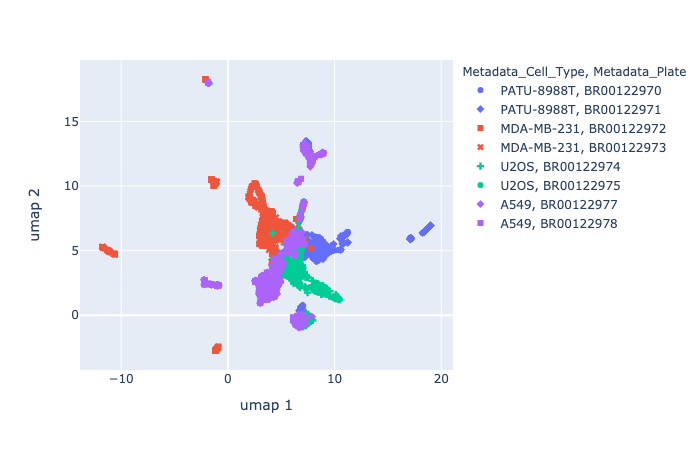

In [5]:
# All wells

fig = px.scatter(
    data_frame=embedded_df,
    x='umap 1',
    y='umap 2',
    color='Metadata_Cell_Type',
    symbol='Metadata_Plate',
    hover_data=['Metadata_broad_sample','Metadata_Supplier_Catalog','Metadata_Well', 'Metadata_Object_Count']
)

fig.show("png")
fig.update_layout(title='All plates - All cell types')
fig.write_image('figures/4.all_plates.png', width='1280', height='960', scale=2)
fig.write_html('figures/4.all_plates.html')

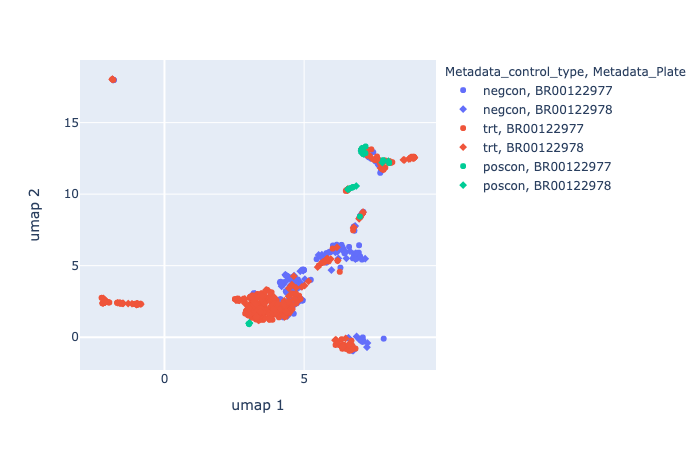

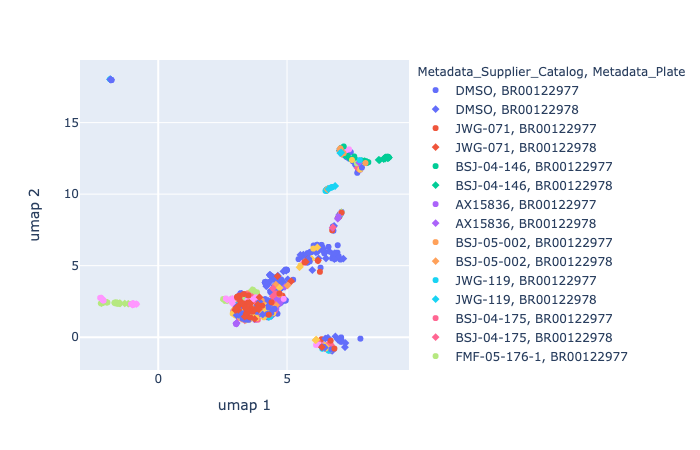

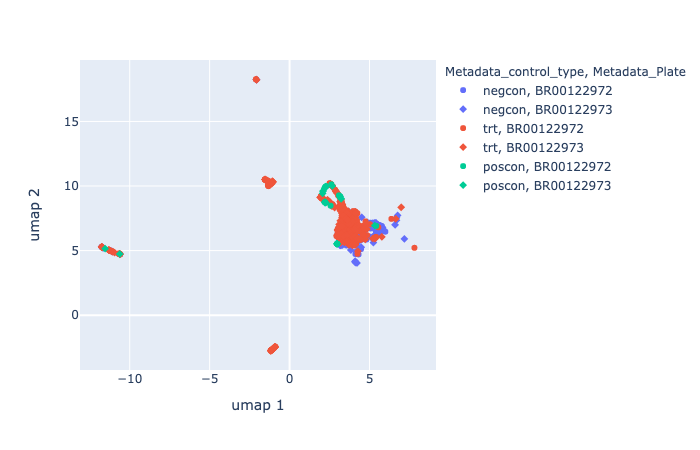

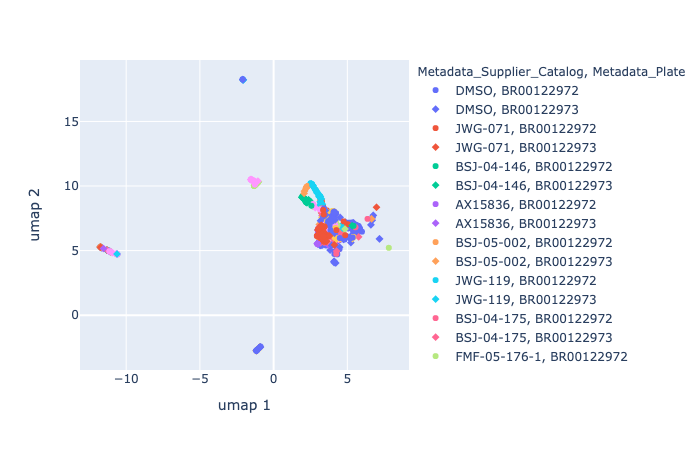

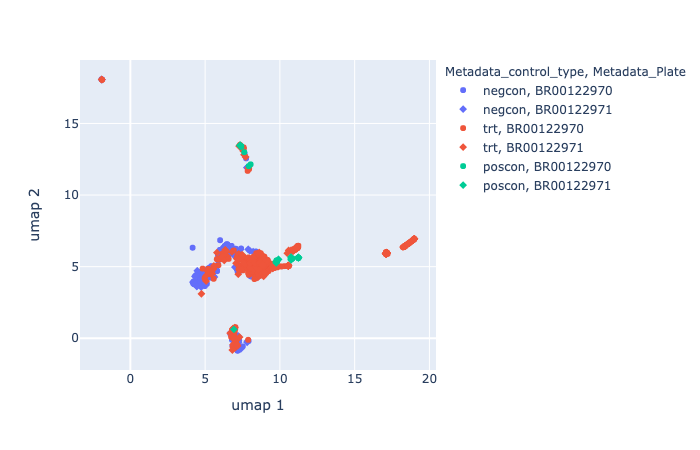

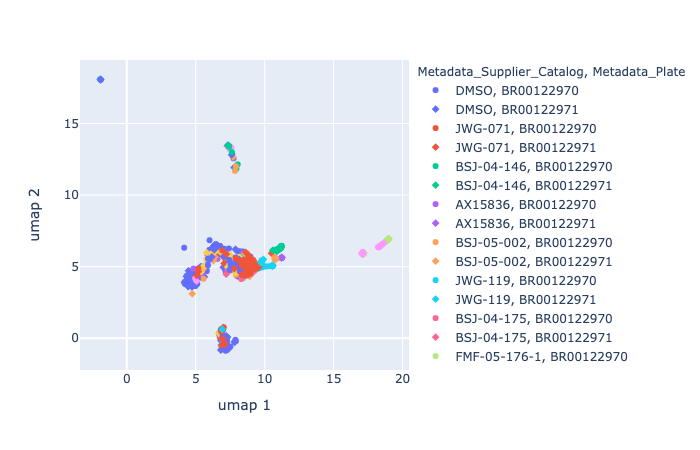

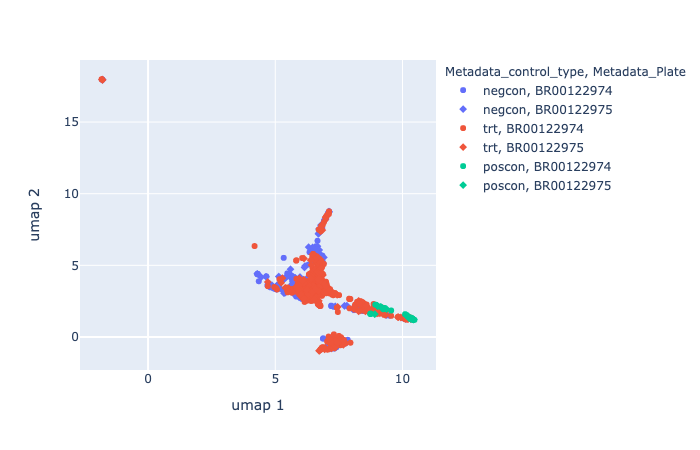

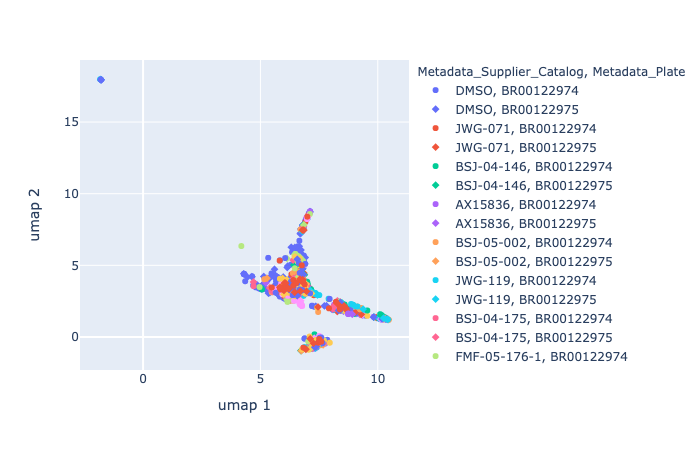

In [6]:
# Group by cell type

for cell_type, grouped in embedded_df.groupby('Metadata_Cell_Type'):
    grouped.Metadata_control_type.replace(np.nan, 'trt', inplace=True)
    fig = px.scatter(
        data_frame=grouped,
        x='umap 1',
        y='umap 2',
        color='Metadata_control_type',
        symbol='Metadata_Plate',
        hover_data=['Metadata_broad_sample','Metadata_Supplier_Catalog','Metadata_Well', 'Metadata_Object_Count']
    )

    fig.show("png")
    fig.update_layout(title=f'{cell_type} both plates')
    fig.write_image(f'figures/4.{cell_type}.png', width='1280', height='960', scale=2)
    fig.write_html(f'figures/4.{cell_type}.html')

    fig = px.scatter(
        data_frame=grouped,
        x='umap 1',
        y='umap 2',
        color='Metadata_Supplier_Catalog',
        symbol='Metadata_Plate',
        hover_data=['Metadata_broad_sample','Metadata_Well', 'Metadata_Object_Count']
    )

    fig.show("png")
    fig.update_layout(title=f'{cell_type} both plates')
    fig.write_image(f'figures/4.{cell_type}_perturbations.png', width='1280', height='960', scale=2)
    fig.write_html(f'figures/4.{cell_type}_perturbations.html')